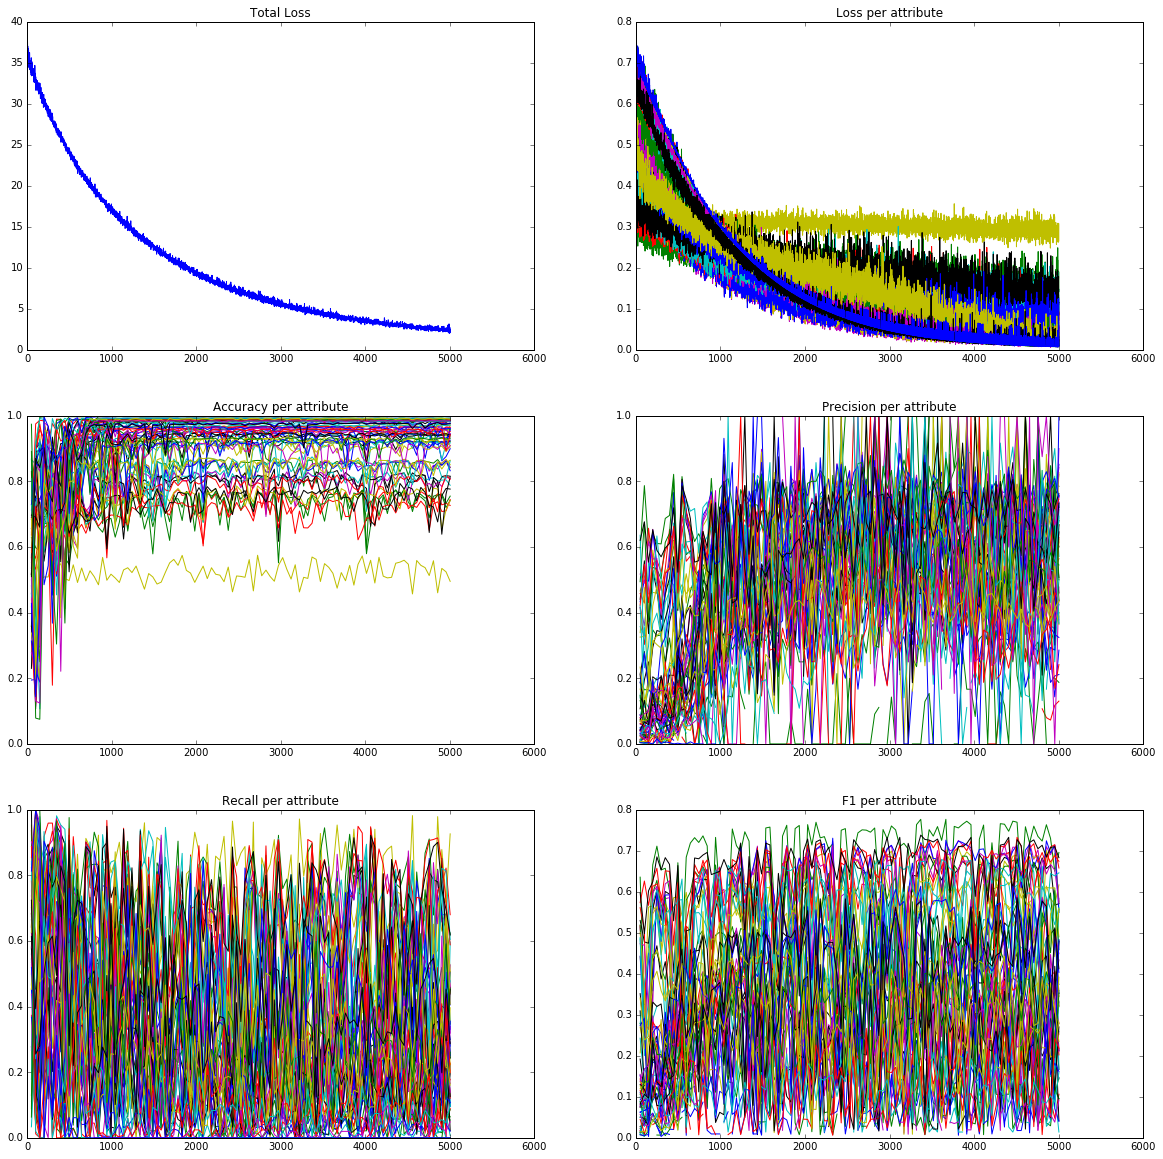

                attr	  f1	 acc	 pre	recall
       Leather(64,2)	nan	0.997	nan	0.000
        Saddle(46,2)	nan	0.992	0.000	0.000
          Horn(44,2)	nan	0.997	nan	0.000
          Rein(45,2)	nan	0.987	0.000	0.000
           Head(9,1)	0.695	0.742	0.785	0.624
         Cloth(56,1)	0.683	0.776	0.763	0.618
         Torso(17,2)	0.674	0.745	0.669	0.680
          Skin(52,1)	0.658	0.807	0.746	0.588
         Metal(53,1)	0.646	0.863	0.694	0.604
       Occluded(6,1)	0.616	0.495	0.462	0.926
         Snout(11,2)	0.584	0.917	0.571	0.597
          Nose(12,2)	0.576	0.843	0.842	0.438
         Mouth(13,2)	0.573	0.851	0.821	0.440
           Arm(19,2)	0.572	0.809	0.759	0.459
          Hair(14,1)	0.571	0.816	0.756	0.459
        Window(25,1)	0.562	0.920	0.681	0.478
    Handlebars(34,1)	0.559	0.971	0.624	0.507
           Eye(16,1)	0.557	0.755	0.720	0.455
          Face(15,2)	0.549	0.832	0.852	0.405
         Wheel(27,2)	0.490	0.905	0.615	0.407
         Furry(57,1)	0.483	0.925	0.752	0.355
        3D Boxy(2,2)	0.4

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import math
import json
import time
import sys
import numpy as np

attr_names = []
for name in open('dataset/attribute/attribute_data/attribute_names.txt').readlines() :
    attr_names.append(name.strip())

loss_weights = []
for line in open('dataset/attribute/attribute_data/balancing_weights.txt').readlines() :
    pl, nl = line.strip().split('\t')
    loss_weights.append( math.sqrt(float(pl)) / ( math.sqrt(float(pl)) + math.sqrt(float(nl)) ) )
    # loss_weights.append( float(pl) / ( float(pl) + float(nl) ) )
    
attr_levels = []
for line in open('attribute_learning_level_v2.txt').readlines() :
    attr_levels.append(int(line.strip()))
    
max_level = np.max(np.array(attr_levels))

while(True):
    try:
        log = open('snapshots/aPascal_weight_balance_root_v2/training.log','r')

        x = []
        loss = []
        la = []
        
        ev_x = []
        acc = []
        pre = []
        recall = []
        f1 = []
        
        
        for i in range(0,64) :
            la.append([])
            acc.append([])
            pre.append([])
            recall.append([])
            f1.append([])

        for line in log.readlines() :
            c = json.loads(line)
            if (c['type'] == 'train') :
                x.append( c['contents']['state']['nEvalCounter'] )
                loss.append( c['contents']['total_loss'] )
                for i in range(0,64) :
                    la[i].append( c['contents']['loss_per_attributes'][attr_levels[i]-1][i] * (loss_weights[i]))
            elif (c['type'] == 'eval') :
                ev_x.append( c['contents']['state']['nEvalCounter'] )
                
                tp = np.array(c['contents']['eval']['tp'],np.float)
                tn = np.array(c['contents']['eval']['tn'],np.float)
                fp = np.array(c['contents']['eval']['fp'],np.float)
                fn = np.array(c['contents']['eval']['fn'],np.float)
                total = (tp + tn + fp + fn)
                
                c_acc = (tp + tn) / total
                c_pre = tp / (tp + fp)
                c_recall = tp / (tp+ fn)
                c_f1 = 2 * c_pre * c_recall / (c_pre + c_recall)
                
                for i in range(0,64) :    
                    acc[i].append(c_acc[attr_levels[i]-1][i])
                    pre[i].append(c_pre[attr_levels[i]-1][i])
                    recall[i].append(c_recall[attr_levels[i]-1][i])
                    f1[i].append(c_f1[attr_levels[i]-1][i])

        plt.close("all")
        f,axes = plt.subplots(3,2)
        f.set_size_inches(20,20)
        axes[0,0].set_title('Total Loss')
        axes[0,1].set_title('Loss per attribute')
        axes[1,0].set_title('Accuracy per attribute')
        axes[1,1].set_title('Precision per attribute')
        axes[2,0].set_title('Recall per attribute')
        axes[2,1].set_title('F1 per attribute')
        
        axes[0,0].plot(x,loss)


        for i in range(0,64) :
            axes[0,1].plot(x, la[i] )
            axes[1,0].plot(ev_x,acc[i])
            axes[1,1].plot(ev_x,pre[i])
            axes[2,0].plot(ev_x,recall[i])
            axes[2,1].plot(ev_x,f1[i])

        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        if( len(ev_x) != 0 ):
            
            
            res = []
            for i in range(0,64) :
                res.append( f1[i][-1] )
            
            kk = np.argsort( res )[::-1]
            
            print '%20s\t%4s\t%4s\t%4s\t%4s'%('attr','f1','acc','pre','recall')
            for k in kk :
                print '%20s\t%0.3f\t%0.3f\t%0.3f\t%0.3f'%(attr_names[k]+'('+str(k+1)+','+str(attr_levels[k])+')', 
                                                          f1[k][-1], 
                                                          acc[k][-1], 
                                                          pre[k][-1], 
                                                          recall[k][-1])
            sys.stdout.flush()
        
    #     plt.show()    
        time.sleep(10.0)
    except KeyboardInterrupt:
        plt.close("all")
        break
    